# Data leakage check & solution

We have identified possible data leakage due to high performance of our models. 
Here we performed additional checks and identified a leakage. 
Although overall it can't be said as real data leakage, in temporal data such us our dataset, using one video in different splits may result in repeating scenes which resembles data leakage. 

To solve this, we ensured our new splits contained videos that belong only to them. 
But we still managed to save the original class distribution. 


In [7]:
def leakage_check(train_videos, val_videos, test_videos):
    train_val_overlap = train_videos & val_videos
    train_test_overlap = train_videos & test_videos
    val_test_overlap = val_videos & test_videos

    print("data leakage analysis:")
    print(f"  train ∩ val:  {len(train_val_overlap)} videos {'leakage!' if train_val_overlap else ''}")
    print(f"  train ∩ test: {len(train_test_overlap)} videos {'leakage!' if train_test_overlap else ''}")
    print(f"  val ∩ test:   {len(val_test_overlap)} videos {'leakage!' if val_test_overlap else ''}")

    if train_val_overlap or train_test_overlap or val_test_overlap:
        print("\nleakage detected: same videos appear in multiple splits.")
        print("examples:")
        if train_val_overlap:
            print(f"  train/val: {list(train_val_overlap)[:5]}")
        if train_test_overlap:
            print(f"  train/test: {list(train_test_overlap)[:5]}")
        if val_test_overlap:
            print(f"  val/test: {list(val_test_overlap)[:5]}")
    else:
        print("\nno data leakage detected, splits look clean.")

In [8]:
# check for data leakage: ensure no base video appears in multiple splits
import pandas as pd
import re
from collections import defaultdict

# read split csvs
train_df = pd.read_csv("/home/zhadiger/Desktop/data_preprocessing/dataset/train.csv")
val_df = pd.read_csv("/home/zhadiger/Desktop/data_preprocessing/dataset/val.csv")
test_df = pd.read_csv("/home/zhadiger/Desktop/data_preprocessing/dataset/test.csv")

print("current dataset overview:")
print(f"  train: {len(train_df)} clips")
print(f"  val:   {len(val_df)} clips")
print(f"  test:  {len(test_df)} clips")
print(f"  total: {len(train_df) + len(val_df) + len(test_df)} clips\n")

# helper to extract P###_V### keys from file paths
def extract_base_video(file_path):
    m = re.search(r'P(\d+)_V(\d+)', file_path)
    if m:
        return f"P{int(m.group(1)):03d}_V{int(m.group(2)):03d}"
    return None

# unique videos by split
train_videos = set(train_df['file_path'].apply(extract_base_video).dropna())
val_videos = set(val_df['file_path'].apply(extract_base_video).dropna())
test_videos = set(test_df['file_path'].apply(extract_base_video).dropna())

print("unique videos per split:")
print(f"  train: {len(train_videos)} unique videos")
print(f"  val:   {len(val_videos)} unique videos")
print(f"  test:  {len(test_videos)} unique videos")
print(f"  total: {len(train_videos | val_videos | test_videos)} unique videos\n")

leakage_check(train_videos, val_videos, test_videos)

current dataset overview:
  train: 2864 clips
  val:   611 clips
  test:  622 clips
  total: 4097 clips

unique videos per split:
  train: 126 unique videos
  val:   109 unique videos
  test:  112 unique videos
  total: 127 unique videos

data leakage analysis:
  train ∩ val:  109 videos leakage!
  train ∩ test: 111 videos leakage!
  val ∩ test:   96 videos leakage!

leakage detected: same videos appear in multiple splits.
examples:
  train/val: ['P474_V003', 'P931_V002', 'P729_V009', 'P540_V006', 'P388_V001']
  train/test: ['P474_V003', 'P931_V002', 'P729_V009', 'P540_V006', 'P388_V001']
  val/test: ['P474_V003', 'P931_V002', 'P729_V009', 'P540_V006', 'P388_V001']


In [10]:
# generate new train/val/test splits without data leakage (video-level)
import numpy as np
from sklearn.model_selection import train_test_split

# combine all data
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"total clips in dataset: {len(all_df)}")

# add base_video column
all_df['base_video'] = all_df['file_path'].apply(extract_base_video)

# group by base_video and class to ensure stratification
video_labels = all_df.groupby('base_video')['label'].first().reset_index()
print(f"total unique videos: {len(video_labels)}")

# show class distribution
print("\nclass distribution across videos:")
print(video_labels['label'].value_counts().sort_index())

# split ratios (approximately 70/15/15)
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# first split: separate test set
train_val_videos, test_videos = train_test_split(
    video_labels,
    test_size=TEST_RATIO,
    random_state=42,
    stratify=video_labels['label']
)

# second split: separate train and val from remaining
train_videos, val_videos = train_test_split(
    train_val_videos,
    test_size=VAL_RATIO / (TRAIN_RATIO + VAL_RATIO),  # adjust ratio for remaining data
    random_state=42,
    stratify=train_val_videos['label']
)

print(f"\nvideo split:")
print(f"  train: {len(train_videos)} videos ({len(train_videos)/len(video_labels)*100:.1f}%)")
print(f"  val:   {len(val_videos)} videos ({len(val_videos)/len(video_labels)*100:.1f}%)")
print(f"  test:  {len(test_videos)} videos ({len(test_videos)/len(video_labels)*100:.1f}%)")

# create sets of video ids
train_video_set = set(train_videos['base_video'])
val_video_set = set(val_videos['base_video'])
test_video_set = set(test_videos['base_video'])

# verify no overlap
assert len(train_video_set & val_video_set) == 0, "train/val overlap detected!"
assert len(train_video_set & test_video_set) == 0, "train/test overlap detected!"
assert len(val_video_set & test_video_set) == 0, "val/test overlap detected!"
print("\nverified: no video leakage between splits!")

# assign clips to splits based on base_video
new_train_df = all_df[all_df['base_video'].isin(train_video_set)].copy()
new_val_df = all_df[all_df['base_video'].isin(val_video_set)].copy()
new_test_df = all_df[all_df['base_video'].isin(test_video_set)].copy()

# remove helper column
new_train_df = new_train_df[['Patient', 'file_path', 'label']]
new_val_df = new_val_df[['Patient', 'file_path', 'label']]
new_test_df = new_test_df[['Patient', 'file_path', 'label']]

print(f"\nclip split:")
print(f"  train: {len(new_train_df)} clips ({len(new_train_df)/len(all_df)*100:.1f}%)")
print(f"  val:   {len(new_val_df)} clips ({len(new_val_df)/len(all_df)*100:.1f}%)")
print(f"  test:  {len(new_test_df)} clips ({len(new_test_df)/len(all_df)*100:.1f}%)")

# per-split class distribution (quick view)
print("\nclass distribution per split (clips):")
print("\ntrain:")
print(new_train_df['label'].value_counts().sort_index())
print("\nval:")
print(new_val_df['label'].value_counts().sort_index())
print("\ntest:")
print(new_test_df['label'].value_counts().sort_index())

total clips in dataset: 4097
total unique videos: 127

class distribution across videos:
label
AbdominalEntry    10
HookCut           22
LocPanoView       19
Needle            13
PanoView          12
Suction           36
UseClipper        15
Name: count, dtype: int64

video split:
  train: 88 videos (69.3%)
  val:   19 videos (15.0%)
  test:  20 videos (15.7%)

verified: no video leakage between splits!

clip split:
  train: 2864 clips (69.9%)
  val:   602 clips (14.7%)
  test:  631 clips (15.4%)

class distribution per split (clips):

train:
label
AbdominalEntry    157
HookCut           583
LocPanoView       274
Needle            394
PanoView          119
Suction           741
UseClipper        596
Name: count, dtype: int64

val:
label
AbdominalEntry     63
HookCut           129
LocPanoView        51
Needle             27
PanoView           39
Suction            98
UseClipper        195
Name: count, dtype: int64

test:
label
AbdominalEntry     31
HookCut            86
LocPanoView     

In [11]:
# save new splits to csv and verify leakage again
import os

output_dir = "/home/zhadiger/Desktop/data_preprocessing/dataset"
backup_dir = "/home/zhadiger/Desktop/data_preprocessing/dataset/backup_splits"
os.makedirs(backup_dir, exist_ok=True)

# backup originals if present
print("creating backup of original split files...")
for filename in ['train.csv', 'val.csv', 'test.csv']:
    src = os.path.join(output_dir, filename)
    dst = os.path.join(backup_dir, filename)
    if os.path.exists(src):
        import shutil
        shutil.copy2(src, dst)
        print(f"backed up {filename}")

# save new splits
print("\nsaving new split files (without data leakage)...")
new_train_df.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
new_val_df.to_csv(os.path.join(output_dir, 'val.csv'), index=False)
new_test_df.to_csv(os.path.join(output_dir, 'test.csv'), index=False)
print("train.csv saved")
print("val.csv saved")
print("test.csv saved")

# verification: re-read and check
print("final verification")

verify_train = pd.read_csv(os.path.join(output_dir, 'train.csv'))
verify_val = pd.read_csv(os.path.join(output_dir, 'val.csv'))
verify_test = pd.read_csv(os.path.join(output_dir, 'test.csv'))

verify_train_videos = set(verify_train['file_path'].apply(extract_base_video).dropna())
verify_val_videos = set(verify_val['file_path'].apply(extract_base_video).dropna())
verify_test_videos = set(verify_test['file_path'].apply(extract_base_video).dropna())

print(f"\nclips per split:")
print(f"train: {len(verify_train)} clips from {len(verify_train_videos)} videos")
print(f"val:   {len(verify_val)} clips from {len(verify_val_videos)} videos")
print(f"test:  {len(verify_test)} clips from {len(verify_test_videos)} videos")

# final leakage check
leakage_check(verify_train_videos, verify_val_videos, verify_test_videos)

# summary stats

print("summary")
print("="*70)
total_clips = len(verify_train) + len(verify_val) + len(verify_test)
total_videos = len(verify_train_videos | verify_val_videos | verify_test_videos)

print(f"\ndataset statistics:")
print(f"total unique videos: {total_videos}")
print(f"total clips: {total_clips}")
print(f"average clips per video: {total_clips/total_videos:.1f}")

print(f"\nsplit ratios:")
print(f"train: {len(verify_train)/total_clips*100:.1f}% clips, {len(verify_train_videos)/total_videos*100:.1f}% videos")
print(f"val:   {len(verify_val)/total_clips*100:.1f}% clips, {len(verify_val_videos)/total_videos*100:.1f}% videos")
print(f"test:  {len(verify_test)/total_clips*100:.1f}% clips, {len(verify_test_videos)/total_videos*100:.1f}% videos")


creating backup of original split files...
backed up train.csv
backed up val.csv
backed up test.csv

saving new split files (without data leakage)...
train.csv saved
val.csv saved
test.csv saved
final verification

clips per split:
train: 2864 clips from 88 videos
val:   602 clips from 19 videos
test:  631 clips from 20 videos
data leakage analysis:
  train ∩ val:  0 videos 
  train ∩ test: 0 videos 
  val ∩ test:   0 videos 

no data leakage detected, splits look clean.
summary

dataset statistics:
total unique videos: 127
total clips: 4097
average clips per video: 32.3

split ratios:
train: 69.9% clips, 69.3% videos
val:   14.7% clips, 15.0% videos
test:  15.4% clips, 15.7% videos


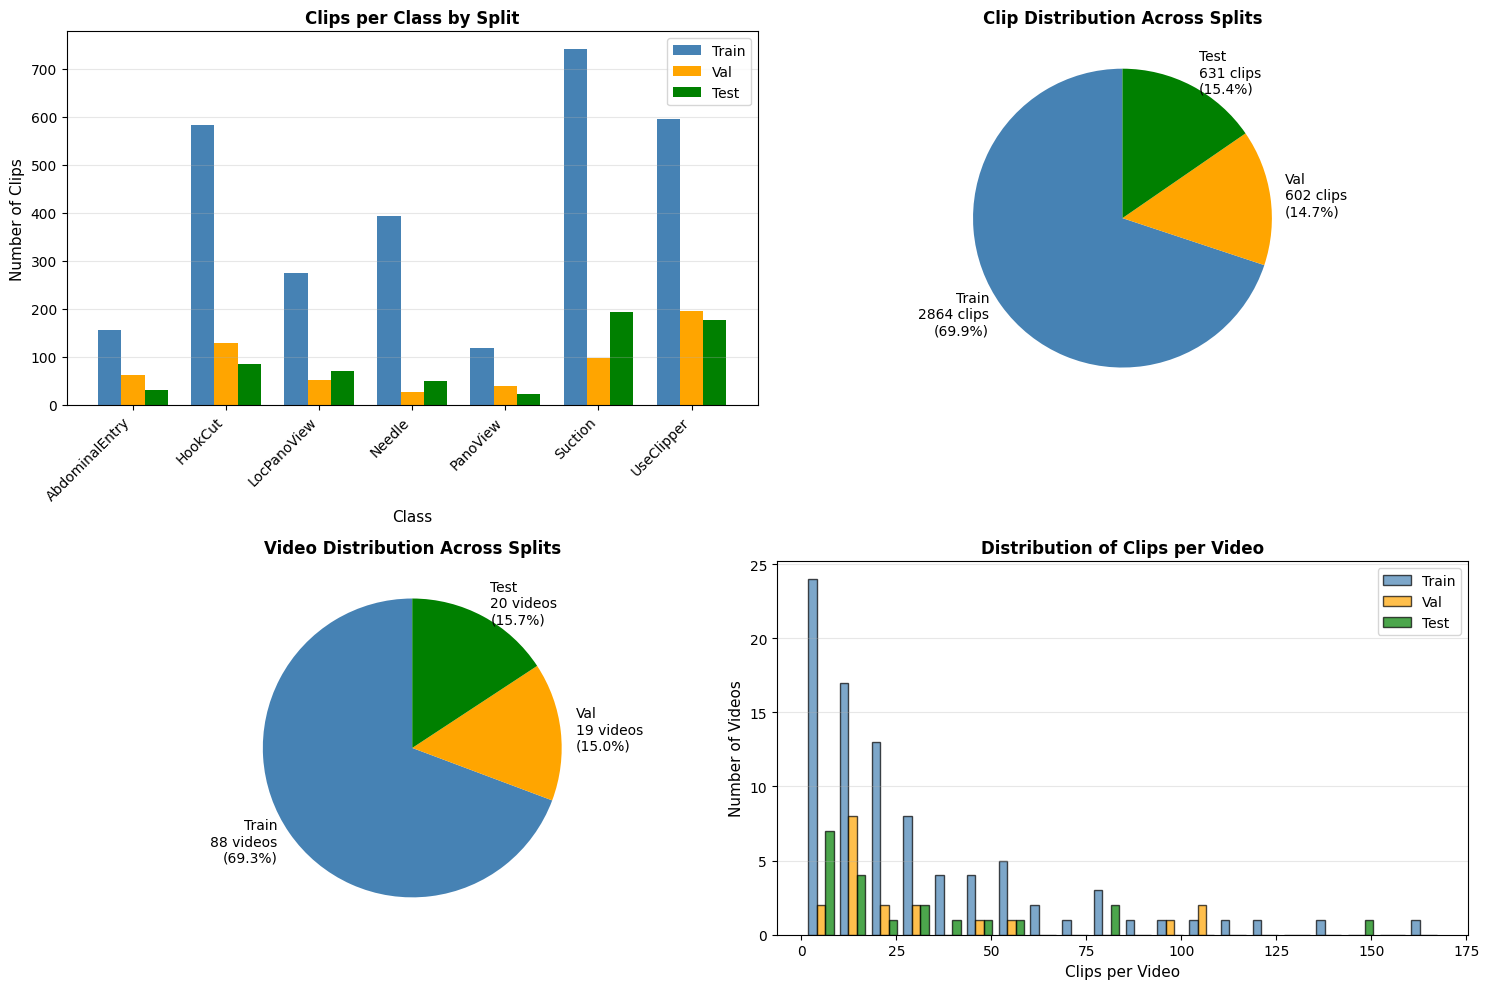


split visualization complete!


In [12]:
# visualize split distributions (clips by class, split sizes, videos per split, clips/video)
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# plot 1: class distribution comparison (clips)
classes = sorted(new_train_df['label'].unique())
train_counts = [len(new_train_df[new_train_df['label'] == c]) for c in classes]
val_counts = [len(new_val_df[new_val_df['label'] == c]) for c in classes]
test_counts = [len(new_test_df[new_test_df['label'] == c]) for c in classes]

x = np.arange(len(classes))
width = 0.25

axes[0, 0].bar(x - width, train_counts, width, label='Train', color='steelblue')
axes[0, 0].bar(x, val_counts, width, label='Val', color='orange')
axes[0, 0].bar(x + width, test_counts, width, label='Test', color='green')
axes[0, 0].set_xlabel('Class', fontsize=11)
axes[0, 0].set_ylabel('Number of Clips', fontsize=11)
axes[0, 0].set_title('Clips per Class by Split', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(classes, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# plot 2: split sizes (pie chart for clips)
split_sizes = [len(new_train_df), len(new_val_df), len(new_test_df)]
split_labels = [f'Train\n{len(new_train_df)} clips\n({len(new_train_df)/sum(split_sizes)*100:.1f}%)',
                f'Val\n{len(new_val_df)} clips\n({len(new_val_df)/sum(split_sizes)*100:.1f}%)',
                f'Test\n{len(new_test_df)} clips\n({len(new_test_df)/sum(split_sizes)*100:.1f}%)']
colors = ['steelblue', 'orange', 'green']

axes[0, 1].pie(split_sizes, labels=split_labels, colors=colors, autopct='', startangle=90)
axes[0, 1].set_title('Clip Distribution Across Splits', fontsize=12, fontweight='bold')

# plot 3: video distribution per split
video_sizes = [len(verify_train_videos), len(verify_val_videos), len(verify_test_videos)]
video_labels = [f'Train\n{len(verify_train_videos)} videos\n({len(verify_train_videos)/sum(video_sizes)*100:.1f}%)',
                f'Val\n{len(verify_val_videos)} videos\n({len(verify_val_videos)/sum(video_sizes)*100:.1f}%)',
                f'Test\n{len(verify_test_videos)} videos\n({len(verify_test_videos)/sum(video_sizes)*100:.1f}%)']

axes[1, 0].pie(video_sizes, labels=video_labels, colors=colors, autopct='', startangle=90)
axes[1, 0].set_title('Video Distribution Across Splits', fontsize=12, fontweight='bold')

# plot 4: clips per video distribution
train_clips_per_video = new_train_df.groupby(new_train_df['file_path'].apply(extract_base_video)).size()
val_clips_per_video = new_val_df.groupby(new_val_df['file_path'].apply(extract_base_video)).size()
test_clips_per_video = new_test_df.groupby(new_test_df['file_path'].apply(extract_base_video)).size()

axes[1, 1].hist([train_clips_per_video, val_clips_per_video, test_clips_per_video], 
                bins=20, label=['Train', 'Val', 'Test'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Clips per Video', fontsize=11)
axes[1, 1].set_ylabel('Number of Videos', fontsize=11)
axes[1, 1].set_title('Distribution of Clips per Video', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nsplit visualization complete!")

classes found: AbdominalEntry, HookCut, LocPanoView, Needle, PanoView, Suction, UseClipper

old split counts (from backup_splits):


,Test,Train,Val
Class,,,
AbdominalEntry,39,175,37
HookCut,121,558,119
LocPanoView,60,277,59
Needle,72,329,70
PanoView,28,125,27
Suction,156,723,154
UseClipper,146,677,145



new split counts (current dataset):


,Test,Train,Val
Class,,,
AbdominalEntry,31,157,63
HookCut,86,583,129
LocPanoView,71,274,51
Needle,50,394,27
PanoView,22,119,39
Suction,194,741,98
UseClipper,177,596,195



change (new - old):


,Test,Train,Val
Class,,,
AbdominalEntry,-8,-18,26
HookCut,-35,25,10
LocPanoView,11,-3,-8
Needle,-22,65,-43
PanoView,-6,-6,12
Suction,38,18,-56
UseClipper,31,-81,50


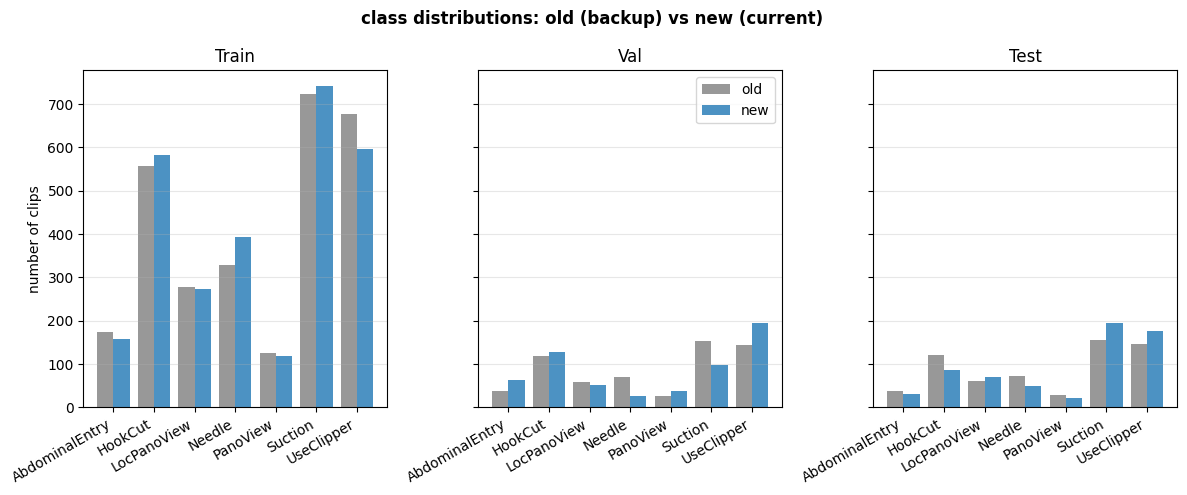


comparison complete.


In [14]:
# compare class distributions: old (backup_splits) vs new (current dataset)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

old_dir = "/home/zhadiger/Desktop/data_preprocessing/dataset/backup_splits"
new_dir = "/home/zhadiger/Desktop/data_preprocessing/dataset"

paths = {
    "Train": (os.path.join(old_dir, "train.csv"), os.path.join(new_dir, "train.csv")),
    "Val":   (os.path.join(old_dir, "val.csv"),   os.path.join(new_dir, "val.csv")),
    "Test":  (os.path.join(old_dir, "test.csv"),  os.path.join(new_dir, "test.csv")),
}

# load dataframes (old, new) for each split if available
old_dfs = {}
new_dfs = {}
for split, (old_p, new_p) in paths.items():
    old_dfs[split] = pd.read_csv(old_p) if os.path.exists(old_p) else None
    new_dfs[split] = pd.read_csv(new_p) if os.path.exists(new_p) else None

# collect unified class list across all available CSVs
class_sets = []
for df in list(old_dfs.values()) + list(new_dfs.values()):
    if isinstance(df, pd.DataFrame) and "label" in df.columns:
        class_sets.append(set(df["label"].unique()))
all_classes = sorted(set().union(*class_sets)) if class_sets else []

if not all_classes:
    print("no classes found. ensure your CSVs have a 'label' column and are present.")
else:
    # build per-split count tables for old and new
    def counts_for(df: pd.DataFrame, classes: list[str]) -> list[int]:
        if df is None:
            return [0] * len(classes)
        vc = df["label"].value_counts()
        return [int(vc.get(cls, 0)) for cls in classes]

    old_counts = pd.DataFrame({split: counts_for(df, all_classes) for split, df in old_dfs.items()}, index=all_classes)
    new_counts = pd.DataFrame({split: counts_for(df, all_classes) for split, df in new_dfs.items()}, index=all_classes)

    # ensure all three columns exist
    for df in (old_counts, new_counts):
        for col in ["Train", "Val", "Test"]:
            if col not in df.columns:
                df[col] = 0
        df.sort_index(axis=1, inplace=True)

    print("classes found:", ", ".join(all_classes))

    print("\nold split counts (from backup_splits):")
    display(old_counts.rename_axis("Class"))

    print("\nnew split counts (current dataset):")
    display(new_counts.rename_axis("Class"))

    # differences table (new - old)
    diff_counts = (new_counts - old_counts).astype(int)
    print("\nchange (new - old):")
    display(diff_counts.rename_axis("Class"))

    # visualize per split: old vs new side-by-side bars
    num_classes = len(all_classes)
    x = np.arange(num_classes)
    width = 0.4

    fig, axes = plt.subplots(1, 3, figsize=(max(12, num_classes * 0.8), 5), sharey=True)
    split_names = ["Train", "Val", "Test"]
    colors = {"old": "tab:gray", "new": "tab:blue"}

    for i, split in enumerate(split_names):
        ax = axes[i]
        old_vals = old_counts[split].values if split in old_counts.columns else np.zeros(num_classes, dtype=int)
        new_vals = new_counts[split].values if split in new_counts.columns else np.zeros(num_classes, dtype=int)
        ax.bar(x - width/2, old_vals, width, label="old", color=colors["old"], alpha=0.8)
        ax.bar(x + width/2, new_vals, width, label="new", color=colors["new"], alpha=0.8)
        ax.set_title(f"{split}")
        ax.set_xticks(x)
        ax.set_xticklabels(all_classes, rotation=30, ha="right")
        ax.grid(axis="y", alpha=0.3)
        if i == 0:
            ax.set_ylabel("number of clips")
        if i == 1:
            ax.legend(loc="upper right")

    fig.suptitle("class distributions: old (backup) vs new (current)", fontsize=12, fontweight="bold")
    fig.tight_layout()
    plt.show()

    print("\ncomparison complete.")